# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [3]:
!pip install datasets

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Download the dataset

In [4]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

Filter row with length greater than 8.


In [5]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)


Create a tokenizer and Detokenizer

In [10]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]


detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

Remove from corpus the sentences where any unknow word appears

In [11]:
mask = np.sum( (sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [12]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [13]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return data_batch , result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [14]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [93]:
BATCH_SIZE = 32

In [94]:
train_generator = DataGenerator(shuffled_data[:220000], batch_size=BATCH_SIZE)
test_generator = DataGenerator(shuffled_data[220000:], batch_size=BATCH_SIZE)

In [17]:
x, y = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")

original:  <start> all organisms cause changes in the environment in which they live <end>
shuffled:  <start> changes cause they live which the organisms all in environment in <end>


original:  <start> most business people have meetings on a daily basis <end>
shuffled:  <start> basis daily business on meetings a people have most <end>


original:  <start> humans thrive on stress because it makes life more interesting <end>
shuffled:  <start> it humans interesting because life makes stress thrive more on <end>


original:  <start> some bacteria can take up dna from the environment <comma> a process called transformation <end>
shuffled:  <start> environment bacteria some from the called dna process transformation <comma> a take up can <end>


original:  <start> flowers are rich source of vitamin c and have sweet taste <end>
shuffled:  <start> sweet flowers are and c source vitamin have taste rich of <end>


original:  <start> antihistamines make a good sleep aid for people with occasion

In [95]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  return (match.size/max(len(p),len(s)))

In [19]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


In [20]:
import numpy as np
import tensorflow as tf
import keras.backend as k
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence

# Project Description: Sentence Reordering

## Overview
The project focuses on building a model for reordering shuffled sentences. Given a pair of shuffled and ordered sentences, the model generates multiple triplets. Each triplet consists of the shuffled sentence, a partial segment of the ordered sentence, and the complete ordered sentence.

## Methodology
1. **Data Preparation:**
   - Training data comprises pairs of shuffled and ordered sentences.
   - For each pair, multiple triplets are created by selecting a portion of the ordered sentence and pairing it with the corresponding shuffled sentence.

2. **Model Objective:**
   - The model aims to learn the relationship between the shuffled sentence, the partial segment of the ordered sentence, and the complete ordered sentence.
   - It does so by encoding the shuffled sentence and the partial segment of the ordered sentence into a fixed-dimensional representation.

3. **Training Procedure:**
   - During training, the model is fed with the shuffled sentence and the partial segment of the ordered sentence to predict the complete ordered sentence.
   - The training process involves minimizing a loss function that penalizes deviations between the predicted and actual ordered sentences.

4. **Inference:**
   - During inference, the model predicts the complete ordered sentence given a shuffled sentence and a partial segment of the ordered sentence.
   - This enables the reordering of shuffled sentences to reconstruct the original ordering.

## Objective
The primary goal of the project is to develop a model capable of accurately reordering shuffled sentences. By understanding the relationship between the shuffled and ordered sentences, the model facilitates the reconstruction of the original sentence ordering.




# Dataset

We are going to create

In [96]:
def extract_full_data(generator):
    x_list = []
    y_list = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        x_list.append(x_batch)
        y_list.append(y_batch)
    x = np.concatenate(x_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return x, y

def prepare_dataset(X, Y):
    c_set = pad_sequences(np.array([s[1:] for s in X]), maxlen=28, padding='post')
    x_set = Y
    y_set = pad_sequences(np.array([s[1:] for s in Y]), maxlen=28, padding='post')
    context = []
    labels = []
    inputs= []

    for j, x in enumerate(x_set):
        non_null_count = sum(x > 0) - 2
        for i in range(non_null_count):
            context.append(c_set[j])
            inputs.append(pad_sequences([x[:i+1]], maxlen=28, padding='post')[0])
            labels.append(y_set[j])

    return np.array(context), np.array(inputs), np.array(labels)


class TrasnformerDataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data_generator = DataGenerator(data, batch_size=batch_size)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        x, y = extract_full_data(self.data_generator)
        self.dataset = prepare_dataset(x, y)
        self.indexes = np.arange(len(self.dataset[0]))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataset[0]) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        context = self.dataset[0][indexes].copy()
        inputs = self.dataset[1][indexes].copy()
        labels = self.dataset[2][indexes].copy()
        return (context, inputs), labels

    def on_epoch_end(self):
        self.data_generator.on_epoch_end()
        x, y = extract_full_data(self.data_generator)
        self.dataset = prepare_dataset(x, y)
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [97]:
x_train, y_train = extract_full_data(train_generator)
x_train.shape, y_train.shape

((220000, 28), (220000, 28))

In [98]:
x_test, y_test = extract_full_data(test_generator)
x_test.shape, y_test.shape

((21216, 28), (21216, 28))

In [24]:
x_train.shape

(219904, 28)

In [99]:
transformer_train_generator = TrasnformerDataGenerator(shuffled_data[:200000], batch_size=BATCH_SIZE)
transformer_val_generator = TrasnformerDataGenerator(shuffled_data[200000:220000], batch_size=BATCH_SIZE)

In [47]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedder, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = embedder
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x

In [49]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.attention_layer = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layer_normalization = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.add_layer = tf.keras.layers.Add()

    def call(self, x, context):
        attention_output = self.attention_layer(query=x,
                                                   key=context,
                                                   value=context,
                                                   attention_mask=mask
                                                   )
        x = self.add_layer([x, attention_output])
        return self.layer_normalization(x)

    
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, use_causal_mask, **kwargs):
        super().__init__()
        self.attention_layer = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layer_normalization = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.add_layer = tf.keras.layers.Add()
        self.use_causal_mask = use_causal_mask
    def call(self, x):
        attn_output = self.attention_layer(
            query=x,
            value=x,
            key=x,
            use_causal_mask=self.use_causal_mask
        )
        x = self.add_layer([x, attn_output])
        return self.layer_normalization(x)


In [50]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [51]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # The last attention scores are cached for later plotting
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [52]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, embedder, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = embedder

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x


class Decoder(tf.keras.layers.Layer):
  def __init__(self, embedder, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(embedder, vocab_size=vocab_size, d_model=d_model)

    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x



In [53]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.embedder = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
    self.encoder = Encoder(self.embedder,num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(self.embedder,num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # All inputs must be passed in the first argument to use '.fit'

    context, x  = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Keras mask is dropped, so it doesn't scale with losses or metrics.
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [54]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_embedding, warmup_steps=5000):
    super().__init__()

    self.d_embedding = d_embedding
    self.d_embedding = tf.cast(self.d_embedding, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_embedding) * tf.math.minimum(arg1, arg2)


In [55]:
num_layers = 10
d_embedding = 128
d_feed_forward = 512
num_heads = 6
dropout_rate = 0.2
transformer = Transformer(
    num_layers=num_layers,
    d_embedding=d_embedding,
    num_heads=num_heads,
    d_feed_forward=d_feed_forward,
    vocab_size=10_000,
    dropout_rate=dropout_rate)
learning_rate = LearningRateScheduler(d_embedding)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

K_VALUE = 0.97

def loss(label, pred):

    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    final_array = tf.pow(K_VALUE,tf.cast(tf.range(1,28+1),tf.float32))

    mask = tf.cast(mask, dtype=loss.dtype)
    mask*=final_array

    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

transformer.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[accuracy])

transformer.build(input_shape = [(None, 28), (None, 28)])

transformer.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'transformer_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "transformer_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_2 (Encoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Decoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [135]:
import tensorflow as tf
import keras_nlp
import numpy as np

# Positional Encoding Function
def positional_encoding(length, depth):
    depth = depth // 2
    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)
    angle_rates = 1 / (10000 ** depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

# Custom Positional Embedding Class
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_embeddingding):
        super(PositionalEmbedding, self).__init__()
        self.d_embeddingding = d_embeddingding
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_embeddingding, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_embeddingding)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_embeddingding, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x

import keras
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_embedding, num_heads, d_feed_forward, vocab_size, dropout_rate=0.1):
        super(Transformer, self).__init__()
        self.num_layers = num_layers
        self.d_embedding = d_embedding
        self.num_heads = num_heads
        self.d_feed_forward = d_feed_forward
        self.vocab_size = vocab_size
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.encoder_embedding = PositionalEmbedding(self.vocab_size, self.d_embedding)
        self.decoder_embedding = PositionalEmbedding(self.vocab_size, self.d_embedding)
        self.encoder_layers = [keras_nlp.layers.TransformerEncoder(
            intermediate_dim=self.d_feed_forward,
            num_heads=self.num_heads,
            dropout=self.dropout_rate, activation='swish'
        ) for _ in range(self.num_layers)]
        self.encoder_batch_norms = [tf.keras.layers.BatchNormalization() for _ in range(self.num_layers)]

        self.decoder_layers = [keras_nlp.layers.TransformerDecoder(
            intermediate_dim=self.d_feed_forward,
            num_heads=self.num_heads,
            dropout=self.dropout_rate, activation='swish'
        ) for _ in range(self.num_layers)]
        self.final_layer = tf.keras.layers.Dense(self.vocab_size, activation='swish', kernel_regularizer='l2')
        self.decoder_batch_norms = [tf.keras.layers.BatchNormalization() for _ in range(self.num_layers)]
        
    def call(self, inputs):
        context, x = inputs
        context_mask = self.encoder_embedding.compute_mask(context)
        x_mask = self.decoder_embedding.compute_mask(x)

        context = self.encoder_embedding(context)
        for i, layer in enumerate(self.encoder_layers):
            context = layer(context, padding_mask=context_mask)
            context = self.encoder_batch_norms[i](context)  # Batch normalization

        x = self.decoder_embedding(x)
        for i, layer in enumerate(self.decoder_layers):
            x = layer(x, context, decoder_padding_mask=x_mask, encoder_padding_mask=context_mask)
            x = self.decoder_batch_norms[i](x) 

        logits = self.final_layer(x)
        try:
            del logits._keras_mask
        except AttributeError:
            pass
        return logits

num_layers = 16
d_embedding = 128
d_feed_forward = 512
num_heads = 6
dropout_rate = 0.2
vocab_size = 10000

# Instantiate the Transformer Model
transformer = Transformer(
    num_layers=num_layers,
    d_embedding=d_embedding,
    num_heads=num_heads,
    d_feed_forward=d_feed_forward,
    vocab_size=vocab_size,
    dropout_rate=dropout_rate
)

# Learning Rate and Optimizer
learning_rate = LearningRateScheduler(d_embedding)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Custom Loss Function
# K_VALUE = 0.97


def loss(label, pred):

    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

#     final_array = tf.pow(K_VALUE,tf.cast(tf.range(1,28+1),tf.float32))

    mask = tf.cast(mask, dtype=loss.dtype)
#     mask*=final_array

    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

transformer.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[accuracy])

transformer.build(input_shape = [(None, 28), (None, 28)])

In [102]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [103]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [136]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# Callbacks
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

class PrintValLoss(Callback):
    def __init__(self, transformer_val_generator, steps=2000):
        super(PrintValLoss, self).__init__()
        self.transformer_val_generator = transformer_val_generator
        self.steps = steps
        self.best_val_loss = float('inf')  # Initialize best validation loss
        self.best_accuracy = 0  # Initialize best accuracy
        self.wait = 0  # Counter for how many epochs the accuracy hasn't improved
        self.patience = 2  # Number of epochs to wait before early stopping

    def on_batch_end(self, batch, logs=None):
        if batch > 0 and batch % self.steps == 0:
            val_loss, val_accuracy = self.model.evaluate(self.transformer_val_generator, verbose=0)
            print(f'\nBatch {batch}: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            # Check if current accuracy is better than the best so far
            if val_accuracy > self.best_accuracy:
                print(f'\nAccuracy improved from {self.best_accuracy:.4f} to {val_accuracy:.4f}. Saving weights.')
                self.best_accuracy = val_accuracy
                self.model.save_weights('best.weights.h5')  # Save best weights
                self.wait = 0  # Reset wait counter
            else:
                self.wait += 1
                # If accuracy hasn't improved for patience epochs, stop training
                if self.wait >= self.patience:
                    print(f'\nAccuracy did not improve for {self.patience} epochs. Early stopping.')
                    self.model.stop_training = True


print_val_loss_callback = PrintValLoss(transformer_val_generator=transformer_val_generator, steps=10000)


epochs = 3

# checkpoint_filepath = './latest.weights.h5'
# checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     save_best_only=True,
#     monitor='accuracy',# Only save the weights
#     save_freq=1000,          # Save every 1000 weight updates
#     verbose=1                # Verbosity level (optional)
# )
history = transformer.fit(
    transformer_train_generator,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    callbacks=[print_val_loss_callback],
    validation_data = transformer_val_generator
)

Epoch 1/3
    1/77089 ━━━━━━━━━━━━━━━━━━━━ 5979:25:27 279s/step - accuracy: 0.0000e+00 - loss: 11.7420

W0000 00:00:1717960253.062680     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10000/77089 ━━━━━━━━━━━━━━━━━━━━ 1:21:41 73ms/step - accuracy: 0.2792 - loss: 6.1806

W0000 00:00:1717961006.500752     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Batch 10000: Validation Loss: 3.5506, Validation Accuracy: 0.4451

Accuracy improved from 0.0000 to 0.4451. Saving weights.
20000/77089 ━━━━━━━━━━━━━━━━━━━━ 1:17:15 81ms/step - accuracy: 0.3676 - loss: 4.8087
Batch 20000: Validation Loss: 2.9160, Validation Accuracy: 0.5075

Accuracy improved from 0.4451 to 0.5075. Saving weights.
30000/77089 ━━━━━━━━━━━━━━━━━━━━ 1:05:32 84ms/step - accuracy: 0.4169 - loss: 4.1556
Batch 30000: Validation Loss: 2.6572, Validation Accuracy: 0.5406

Accuracy improved from 0.5075 to 0.5406. Saving weights.
40000/77089 ━━━━━━━━━━━━━━━━━━━━ 52:24 85ms/step - accuracy: 0.4496 - loss: 3.7652
Batch 40000: Validation Loss: 2.5125, Validation Accuracy: 0.5575

Accuracy improved from 0.5406 to 0.5575. Saving weights.
50000/77089 ━━━━━━━━━━━━━━━━━━━━ 38:28 85ms/step - accuracy: 0.4729 - loss: 3.5013
Batch 50000: Validation Loss: 2.4058, Validation Accuracy: 0.5727

Accuracy improved from 0.5575 to 0.5727. Saving weights.
57877/77089 ━━━━━━━━━━━━━━━━━━━━ 27:31 86ms

KeyboardInterrupt: 

In [128]:
transformer.count_params()

7536256

In [ ]:
transformer.save_weights("weights_final.weights.h5", overwrite=True)


In [66]:
def generate_prediction(shuffled, model):
    max_count = sum(shuffled > 3)
    generated = pad_sequences(np.array([shuffled[:1]]), maxlen=28, padding='post')[0]
    available_tokens = shuffled[1:sum((shuffled>0))-1].tolist()
    context = pad_sequences(np.array([shuffled[1:]]), maxlen=28, padding='post')[0]
    for count in range(max_count):
        prediction = model.predict((np.array([context]), np.array([generated])), verbose=0)
        relevant_logits = prediction[0, count, available_tokens]
        generated_index = np.argmax(relevant_logits, axis=-1)
        generated_token = available_tokens[generated_index]
        available_tokens.remove(generated_token)
        generated[count+1] = generated_token

    return generated[1:sum(generated>0)]


def get_average_score(x, y, model, print_allowed=False):
    num_examples = len(x)
    rs = []
    gs = []
    for i in range(num_examples):
        shuffled = x[i][1:sum(x[i]>0)-1]
        ordered = y[i][1:sum(y[i]>0)-1]

        rs.append(score(ordered, shuffled))
        gs.append(score(ordered, generate_prediction(x[i],model)))
        if print_allowed:
            print(f'{i+1}.Random: {rs[-1]}')
            print(f'{i+1}.Generated: {gs[-1]}')

    return gs, sum(rs)/num_examples, sum(gs)/num_examples

In [137]:
x_test_length = len(x_test)

# Generate 3000 random indices
random_indices = np.random.choice(x_test_length, 500, replace=False)


In [138]:
gs, average_random_score, average_generated_score = get_average_score(x_test[random_indices], y_test[random_indices], transformer, print_allowed=True)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')

1.Random: 0.14285714285714285
1.Generated: 0.2857142857142857
2.Random: 0.18181818181818182
2.Generated: 0.2727272727272727
3.Random: 0.18181818181818182
3.Generated: 0.2727272727272727
4.Random: 0.11764705882352941
4.Generated: 0.17647058823529413
5.Random: 0.2222222222222222
5.Generated: 1.0
6.Random: 0.058823529411764705
6.Generated: 0.17647058823529413
7.Random: 0.1
7.Generated: 0.5
8.Random: 0.06666666666666667
8.Generated: 0.13333333333333333
9.Random: 0.16666666666666666
9.Generated: 0.5
10.Random: 0.15384615384615385
10.Generated: 0.15384615384615385
11.Random: 0.10526315789473684
11.Generated: 0.47368421052631576
12.Random: 0.07692307692307693
12.Generated: 0.23076923076923078
13.Random: 0.07142857142857142
13.Generated: 0.14285714285714285
14.Random: 0.2222222222222222
14.Generated: 1.0
15.Random: 0.16666666666666666
15.Generated: 0.25
16.Random: 0.11764705882352941
16.Generated: 0.4117647058823529
17.Random: 0.1
17.Generated: 0.2
18.Random: 0.1111111111111111
18.Generated: 0

In [130]:
gs, average_random_score, average_generated_score = get_average_score(x_test[random_indices], y_test[random_indices], transformer, print_allowed=True)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')

1.Random: 0.14285714285714285
1.Generated: 0.2857142857142857
2.Random: 0.18181818181818182
2.Generated: 0.36363636363636365
3.Random: 0.18181818181818182
3.Generated: 0.2727272727272727
4.Random: 0.11764705882352941
4.Generated: 0.29411764705882354
5.Random: 0.2222222222222222
5.Generated: 0.4444444444444444
6.Random: 0.058823529411764705
6.Generated: 0.17647058823529413
7.Random: 0.1
7.Generated: 0.5
8.Random: 0.06666666666666667
8.Generated: 0.13333333333333333
9.Random: 0.16666666666666666
9.Generated: 0.5
10.Random: 0.15384615384615385
10.Generated: 0.46153846153846156
11.Random: 0.10526315789473684
11.Generated: 0.3157894736842105
12.Random: 0.07692307692307693
12.Generated: 0.23076923076923078
13.Random: 0.07142857142857142
13.Generated: 0.14285714285714285
14.Random: 0.2222222222222222
14.Generated: 1.0
15.Random: 0.16666666666666666
15.Generated: 0.5833333333333334
16.Random: 0.11764705882352941
16.Generated: 0.29411764705882354
17.Random: 0.1
17.Generated: 0.2
18.Random: 0.11

In [90]:
transformer.count_params()

20745640

In [89]:
average_random_score, average_generated_score = get_average_score(x_train[2000:2100], y_train[2000:2100], transformer)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')

KeyboardInterrupt: 

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

In [ ]:
import tensorflow as tf
import keras_nlp
import numpy as np

# Positional Encoding Function
def positional_encoding(length, depth):
    depth = depth // 2
    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)
    angle_rates = 1 / (10000 ** depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

# Custom Positional Embedding Class
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_embeddingding):
        super(PositionalEmbedding, self).__init__()
        self.d_embeddingding = d_embeddingding
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_embeddingding, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_embeddingding)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_embeddingding, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x

import keras

@keras.saving.register_keras_serializable()
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_embeddingding, num_heads, d_feed_forward, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super(Transformer, self).__init__()
        self.encoder_embedding = PositionalEmbedding(input_vocab_size, d_embedding)
        self.decoder_embedding = PositionalEmbedding(target_vocab_size, d_embeddingding)
        self.encoder_layers = [keras_nlp.layers.TransformerEncoder(
            intermediate_dim=d_feed_forward,
            num_heads=num_heads,
            dropout=dropout_rate, activation='swish'
        ) for _ in range(num_layers)]
        self.decoder_layers = [keras_nlp.layers.TransformerDecoder(
            intermediate_dim=d_feed_forward,
            num_heads=num_heads,
            dropout=dropout_rate, activation='swish'
        ) for _ in range(num_layers)]
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='swish')

    def call(self, inputs):
        context, x = inputs
        context_mask = self.encoder_embedding.compute_mask(context)
        x_mask = self.decoder_embedding.compute_mask(x)

        context = self.encoder_embedding(context)
        for layer in self.encoder_layers:
            context = layer(context, padding_mask=context_mask)

        x = self.decoder_embedding(x)
        for layer in self.decoder_layers:
            x = layer(x, context, decoder_padding_mask=x_mask, encoder_padding_mask=context_mask)

        logits = self.final_layer(x)
        try:
            del logits._keras_mask
        except AttributeError:
            pass
        return logits

@keras.saving.register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_embeddingding, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_embeddingdind_emd_embeddingodel
        self.d_embeddingding = tf.cast(self.d_embeddingding, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_embedding) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {'d_embedding': self.d_embeddingding, 'warmup_steps': self.warmup_steps}

# Model Hyperparameters
num_layers = 16
d_embeddingding = 128
d_feed_forward = 512
num_heads = 8
dropout_rate = 0.2
input_vocab_size = 10000
target_vocab_size = 10000

# Instantiate the Transformer Model
transformer = Transformer(
    num_layers=num_layers,
    d_embedding=d_embedding,
    num_heads=num_heads,
    d_feed_forward=d_feed_forward,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    dropout_rate=dropout_rate
)

# Learning Rate and Optimizer
learning_rate = CustomSchedule(d_embedding)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Custom Loss Function
K_VALUE = 0.97

def custom_masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)
#     1
#     final_array = tf.pow(K_VALUE, tf.cast(tf.range(1, 28 + 1), tf.float32))
    first_part = tf.pow(K_VALUE, tf.cast(tf.range(1, 6 + 1), tf.float32))
    second_part = tf.pow(K_VALUE, tf.cast(tf.range(1, 22 + 1), tf.float32))

# Reverse the first part
    reversed_first_part = tf.reverse(first_part, axis=[0])

# Concatenate the reversed first part with the second part
    final_array = tf.concat([reversed_first_part, second_part], axis=0)

    mask = tf.cast(mask, dtype=loss.dtype)
    mask *= final_array
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

# Compile the Model
transformer.compile(
    loss=custom_masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy]
)

# Build and Display the Model Summary
transformer.build(input_shape=[(None, 28), (None, 28)])
transformer.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'transformer_21', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.

  warnings.warn(


Model: "transformer_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ positional_embedding_34         │ ?                      │   0 (unbuilt) │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_35         │ ?                      │   0 (unbuilt) │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_177         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_178         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_179         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_180         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_181         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_182         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_183         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_184         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_185         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_186         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_187         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_188         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_189         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_190         │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_191         │ ?                      │   0 (unbuilt

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
es = EarlyStopping(monitor='val_masked_accuracy', mode='max', verbose=1, patience=2)

epochs = 5
batch_size= 128

checkpoint_filepath = '/content/drive/MyDrive/UNIBO_DEEP_LEARNING/latest.weights.h5'
checkpoint_filepath = './latest_2.weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='masked_accuracy',# Only save the weights
    save_freq=1000,          # Save every 1000 weight updates
    verbose=1                # Verbosity level (optional)
)
history = transformer.fit(
    (context_train, inputs_train),
    labels_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint_callback, es],
    validation_data = ((context_val, inputs_val), labels_val)
)

Epoch 1/5


W0000 00:00:1717860699.552913     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  999/19272 ━━━━━━━━━━━━━━━━━━━━ 47:09 155ms/step - loss: 8.0514 - masked_accuracy: 0.1459

Epoch 1: masked_accuracy improved from -inf to 0.21420, saving model to ./latest_2.weights.h5

 1999/19272 ━━━━━━━━━━━━━━━━━━━━ 44:47 156ms/step - loss: 7.0642 - masked_accuracy: 0.2027

Epoch 1: masked_accuracy improved from 0.21420 to 0.30043, saving model to ./latest_2.weights.h5

 2999/19272 ━━━━━━━━━━━━━━━━━━━━ 42:17 156ms/step - loss: 6.3681 - masked_accuracy: 0.2453

Epoch 1: masked_accuracy improved from 0.30043 to 0.35614, saving model to ./latest_2.weights.h5

 3999/19272 ━━━━━━━━━━━━━━━━━━━━ 39:41 156ms/step - loss: 5.8460 - masked_accuracy: 0.2777

Epoch 1: masked_accuracy improved from 0.35614 to 0.39100, saving model to ./latest_2.weights.h5

 4999/19272 ━━━━━━━━━━━━━━━━━━━━ 37:07 156ms/step - loss: 5.4396 - masked_accuracy: 0.3031

Epoch 1: masked_accuracy improved from 0.39100 to 0.41757, saving model to ./latest_2.weights.h5

 5999/19272 ━━━━━━━━━━━━━━━━━━━━ 34:31 156ms/step - l

W0000 00:00:1717863834.616378     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update

W0000 00:00:1717863850.057898     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19272/19272 ━━━━━━━━━━━━━━━━━━━━ 3489s 169ms/step - loss: 3.2404 - masked_accuracy: 0.4651 - val_loss: 1.4043 - val_masked_accuracy: 0.6502

Epoch 2/5

  727/19272 ━━━━━━━━━━━━━━━━━━━━ 47:41 154ms/step - loss: 0.8988 - masked_accuracy: 0.7337

Epoch 2: masked_accuracy improved from 0.58810 to 0.73492, saving model to ./latest_2.weights.h5

 1727/19272 ━━━━━━━━━━━━━━━━━━━━ 45:33 156ms/step - loss: 0.8967 - masked_accuracy: 0.7348

Epoch 2: masked_accuracy improved from 0.73492 to 0.73653, saving model to ./latest_2.weights.h5

 2727/19272 ━━━━━━━━━━━━━━━━━━━━ 43:00 156ms/step - loss: 0.8932 - masked_accuracy: 0.7360

Epoch 2: masked_accuracy improved from 0.73653 to 0.73937, saving model to ./latest_2.weights.h5

 3727/19272 ━━━━━━━━━━━━━━━━━━━━ 40:23 156ms/step - loss: 0.8890 - masked_accuracy: 0.7372

Epoch 2: masked_accuracy improved from 0.73937 to 0.74224, saving model to ./latest_2.weights.h5

 4727/19272 ━━━━━━━━━━━━━━━━━━━━ 37:48 156ms/step - loss: 0.8846 - masked_accuracy: 0.73

KeyboardInterrupt: 

In [ ]:
transformer.summary()

In [ ]:


# Print the combined array
print(combined_array)


tf.Tensor(

[0.83297217 0.85873413 0.8852929  0.91267306 0.9409     0.97

 0.97       0.9409     0.91267306 0.8852929  0.85873413 0.83297217

 0.80798304 0.78374356 0.76023126 0.7374243  0.71530163 0.6938426

 0.67302734 0.65283656 0.6332515  0.61425394 0.5958263  0.5779516

 0.56061304 0.54379463 0.52748084 0.51165646], shape=(28,), dtype=float32)


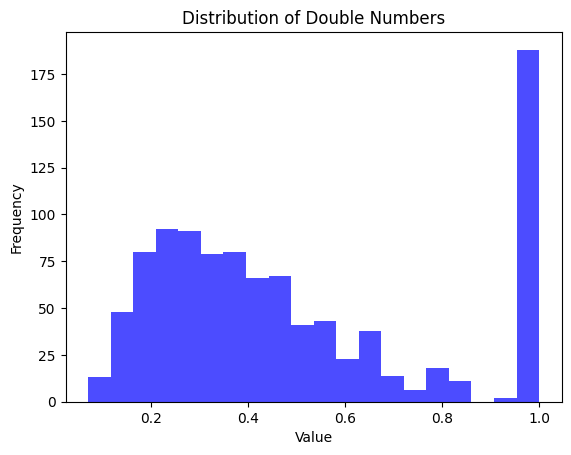

In [92]:
import matplotlib.pyplot as plt
import numpy as np


# Create a histogram
plt.hist(gs, bins=20, alpha=0.7, color='blue')

# Add title and labels
plt.title('Distribution of Double Numbers')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
average_random_score, average_generated_score = get_average_score(x_train[2000:2100], y_train[2000:2100], transformer)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')

In [ ]:
generated_scores, average_random_score, average_generated_score = get_average_score(x_test[2000:3000], y_test[2000:3000], transformer)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')

W0000 00:00:1717867182.235078     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Average score on shuffled data: 0.1437748238947166

Average score on generated data: 0.488652290575781


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Create a histogram
plt.hist(generated_scores, bins=20, alpha=0.7, color='blue')

# Add title and labels
plt.title('Distribution of Double Numbers')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
transformer.summary()

Model: "transformer_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ positional_embedding_34         │ ?                      │     1,280,000 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_35         │ ?                      │     1,280,000 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_177         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_178         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_179         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_180         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_181         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_182         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_183         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_184         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_185         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_186         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_187         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_188         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_189         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_190         │ ?                      │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_191         │ ?                      │       198,27

 Total params: 33,766,705 (128.81 MB)

 Trainable params: 11,255,568 (42.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,511,137 (85.87 MB)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Create a histogram
plt.hist(generated_scores, bins=20, alpha=0.7, color='blue')

# Add title and labels
plt.title('Distribution of Double Numbers')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
import numpy as np

# Assuming you have an array of double numbers
original_array = np.random.normal(loc=0, scale=1, size=10000)  # Example array

# Generate 5000 random indices within the range of the original array length
random_indices = np.random.choice(len(original_array), size=5000, replace=False)

# Get the elements at these random indices
random_elements = original_array[random_indices]

# Print the random indices and the corresponding elements
print("Random Indices:", random_indices)
print("Random Elements:", random_elements)


In [ ]:
def generate_prediction2(shuffled, model):
    max_count = sum(shuffled > 3)
    generated = pad_sequences(np.array([shuffled[:1]]), maxlen=28, padding='post')[0]
    available_tokens = shuffled[1:sum((shuffled>0))-1].tolist()
    context = pad_sequences(np.array([shuffled[1:]]), maxlen=28, padding='post')[0]
    for count in range(max_count):
        prediction = model.predict((np.array([context]), np.array([generated])), verbose=0)
        relevant_logits = prediction[0, count, available_tokens]
        generated_index = np.argmax(relevant_logits, axis=-1)
        generated_token = generated_index
        generated_token = available_tokens[generated_index]
#         available_tokens.remove(generated_token)
        generated[count+1] = generated_token

    generated[sum(generated>0)] = 2
    return generated[:sum(generated>0)]
def get_average_score2(x, y, model):
    num_examples = len(x)
    rs = []
    gs = []
    for i in range(num_examples):
        shuffled = x[i][:sum(x[i]>0)]
        ordered = y[i][:sum(y[i]>0)]

        rs.append(score(ordered, shuffled))
        gs.append(score(ordered, generate_prediction2(x[i],model)))
        print(f'{i+1}.Random: {rs[-1]}')
        print(f'{i+1}.Generated: {gs[-1]}')

    return gs, sum(rs)/num_examples, sum(gs)/num_examples

In [ ]:
generated_scores, average_random_score, average_generated_score = get_average_score2(x_test[2000:3000], y_test[2000:3000], transformer)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')